# Computational Intelligence in Chemistry - Hands-on Linear Feature Selection

### Luis Filipe Menezes - RA: 164924

This is part of an assignment for the Computational Intelligence in Chemistry course on UNIFESP's masters program.

This notebook must:

I. Use same subset of Deliverable 3

II.Compute the representations using the following methods: EV-CM and MBTR

III.Feature Evaluation / Feature Selection:
  
 - I. Build a LASSO regressor for the bandgap property
  
 - II. Rank the features

 - III. Select the minimum subset of features to reach 95% of the accuracy considering the full set of features (for each MR)

IV.Analysis:
- I. Execution time for each method (full)
- II. Plot the accuracy degradation versus percentage of features
- III. Number of top features to reach 95% accuracy
- IV. Plot scatter plots with the PCA and t-SNE representation for both
scenarios

## I. Using the same subset of Deliverable 3:
Here, we will select the same archives as deliverable 3, although now we need the .xyz coordinates for each atom instead of the SMILES string.

In [2]:
!pip install dscribe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.4/777.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 11.4 MB/s eta 0:00:00


In [3]:
!wget -O data.tar.bz2 https://www.dropbox.com/scl/fi/2ugqxr9fa9nob1byc8ura/dsgdb9nsd.xyz.tar.bz2?rlkey=pp2k6fy4360yldrypwghwbi6d&st=1cohswqh&dl=0
!!mkdir qm9_files
!tar -xjf data.tar.bz2 -C qm9_files/

--2025-10-27 18:42:01--  https://www.dropbox.com/scl/fi/2ugqxr9fa9nob1byc8ura/dsgdb9nsd.xyz.tar.bz2?rlkey=pp2k6fy4360yldrypwghwbi6d
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb7b60e5aee4e034e5c60872215.dl.dropboxusercontent.com/cd/0/inline/C0C4oKOTrGXknvElF_wWEbNPQAFGxEFygVx5u2iZjcldjEpIZEro4cMm6mLKyuKelWZG4YvaIp_HvkPLZeIJYgZwFrdWNYQtNLTykM9mxPYhaiaHKdXum-kAjWYLdDcbDx7heKWHGeacmKtTUqlbsNaa/file# [following]
--2025-10-27 18:42:02--  https://ucb7b60e5aee4e034e5c60872215.dl.dropboxusercontent.com/cd/0/inline/C0C4oKOTrGXknvElF_wWEbNPQAFGxEFygVx5u2iZjcldjEpIZEro4cMm6mLKyuKelWZG4YvaIp_HvkPLZeIJYgZwFrdWNYQtNLTykM9mxPYhaiaHKdXum-kAjWYLdDcbDx7heKWHGeacmKtTUqlbsNaa/file
Resolving ucb7b60e5aee4e034e5c60872215.dl.dropboxusercontent.com (ucb7b60e5aee4e034e5c60872215.dl.dropboxusercontent.com)... 162.125.5.1

In [4]:
qm9_folder = 'qm9_files/'
QM9_PROPERTIES = [
    "A", 'B', 'C', 'mu', 'alpha',
    'homo', 'lumo', 'gap', 'r2',
    'zpve', 'U0', 'U', 'H', 'G', 'Cv'
]


with open(qm9_folder+'dsgdb9nsd_113885.xyz') as file:
  for line in file:
    print(line)


19

gdb 113885	3.70802	0.80999	0.7081	2.6975	73.65	-0.2639	0.0141	0.278	1593.5236	0.156316	-460.174889	-460.164623	-460.163679	-460.212278	35.326	

C	-0.008898706	 1.435343511	-0.1229342875	-0.480889

C	-0.097211668	-0.0611740136	 0.0533750899	 0.431334

O	-0.522805097	-0.6329577977	 1.0223608396	-0.34442

O	 0.3874153201	-0.692641184	-1.0454419183	-0.247509

C	 0.3502508225	-2.1099666389	-1.0216443391	 0.118249

C	-0.6452778548	-2.8049992501	-1.9010293635	-0.305338

C	 0.8299955957	-2.806393386	-2.257736521	-0.04378

C	 1.3090797685	-2.0281448361	-3.4552388748	-0.093611

O	 1.0953742585	-2.8320000843	-4.6085691448	-0.419869

H	-0.3728027153	 1.9278328937	 0.7777832851	 0.149542

H	 1.0248947898	 1.7315350968	-0.3210999853	 0.149596

H	-0.6070917791	 1.7459702376	-0.9844780335	 0.149165

H	 0.576972916	-2.5190329042	-0.0453019279	 0.12476

H	-1.1102986284	-3.7153217605	-1.5406769745	 0.122235

H	-1.2860640388	-2.1730656326	-2.5065209428	 0.123942

H	 1.3703384329	-3.7344941519	-2.09474

In [5]:
import os
import pandas as pd
import numpy as np
from ase import Atoms


np.random.seed(24)
N_SUBSET_SAMPLES = 5000

def load_validate_mol(file_string):
  with open(file_string, 'r') as file:
    n_atoms = int(file.readline())

    properties_list = file.readline().split()
    mol_id = properties_list[1]
    properties_values = [float(prop) for prop in properties_list[2:]]
    properties_dict = dict(zip(QM9_PROPERTIES, properties_values))


    atoms = []
    atoms_coords = []
    for nlines in range(n_atoms):
      atom_info = file.readline().split()
      atoms.append(atom_info[0]) # get only the the atom string

      atom_coords_str = atom_info[1:4]
      # print(atom_coords)
      try:
        atom_coords = [float(coord.replace('*^', 'e')) for coord in atom_coords_str]
        atoms_coords.append(atom_coords)

      except Exception as e:
        print(f"Couldn't extract xyz from file {file_string}: ", e)
      # print(atom_info)
    # print(atoms)
    file.readline() # ignores the frequencies

    # smiles_list = file.readline().split()


    # mol = Chem.MolFromSmiles(smiles_list[0]) # If it's None then smiles is invalid
    # if mol is None:
    #     print("Invalid smiles for arquive: ", mol_id)
    #     return
    # canon_smiles = Chem.CanonSmiles(smiles_list[0])

    mol_ase = Atoms(symbols=atoms, positions= atoms_coords)

    molecule_data = {
                'id': mol_id,
                'n_atoms': n_atoms,
                'atom_list': atoms,
                'atom_coords': atoms_coords,
                'mol_ase': mol_ase,
                # 'smiles': canon_smiles,
            }
            # Adiciona as 12 propriedades ao dicionário principal
    molecule_data.update(properties_dict)
    return molecule_data


def get_full_dataset(folder):
  dataset_list = []
  # print(f"Lendo arquivos da pasta: {folder}")

  files_to_process = [f for f in os.listdir(folder) if f.endswith('.xyz')]

  files_to_process = np.random.choice(files_to_process, size=N_SUBSET_SAMPLES, replace=False)

  n_max_atoms = -1

  for i, file in enumerate(files_to_process):

      if (i + 1) % 1000 == 0:
          print(f"  Processando arquivo {i+1}/{len(files_to_process)}...")

      file_path = os.path.join(folder, file)

      # Chama a função de processamento para um arquivo
      molecule_data = load_validate_mol(file_path)

      n_atoms = molecule_data['n_atoms']
      if n_atoms > n_max_atoms:
          n_max_atoms = n_atoms
      # Se a função retornou dados válidos (não None), adiciona à lista
      if molecule_data:
          dataset_list.append(molecule_data)
  return dataset_list, n_max_atoms




if __name__ == '__main__':
  full_dataset, n_max_atoms = get_full_dataset(qm9_folder)

  df = pd.DataFrame(full_dataset)
  display(df.head())
  # print(load_validate_mol(qm9_folder+'dsgdb9nsd_113885.xyz')['atom_coords'])

  Processando arquivo 1000/5000...
  Processando arquivo 2000/5000...
  Processando arquivo 3000/5000...
  Processando arquivo 4000/5000...
  Processando arquivo 5000/5000...


,id,n_atoms,atom_list,atom_coords,mol_ase,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
0,39556,18,"[C, C, C, C, C, C, C, C, N, H, H, H, H, H, H, ...","[[-0.0264069831, 1.4142945362, -0.0241179453],...","(Atom('C', [np.float64(-0.0264069831), np.floa...",3.90391,1.68667,1.51652,1.0662,80.72,-0.2072,-0.0034,0.2038,912.5094,0.150671,-364.761507,-364.755298,-364.754354,-364.791533,27.177
1,100958,23,"[C, C, C, O, C, O, C, C, C, H, H, H, H, H, H, ...","[[2.2952934683, 1.6908054719, 0.0684492335], [...","(Atom('C', [np.float64(2.2952934683), np.float...",2.15346,1.17184,0.96439,0.2361,81.91,-0.2490,0.0739,0.3229,1371.1332,0.202818,-425.410716,-425.399753,-425.398809,-425.446294,40.757
2,39019,19,"[C, C, C, C, C, C, O, C, C, H, H, H, H, H, H, ...","[[0.0845419636, 1.6090402549, 0.2589732214], [...","(Atom('C', [np.float64(0.0845419636), np.float...",2.99660,1.70625,1.25887,1.5438,81.21,-0.2325,0.0219,0.2544,1026.3644,0.161618,-385.873063,-385.865979,-385.865035,-385.904352,28.912
3,47634,16,"[O, C, C, C, N, C, C, C, O, H, H, H, H, H, H, H]","[[-0.1163593684, 1.012433012, -1.5958913417], ...","(Atom('O', [np.float64(-0.1163593684), np.floa...",2.49417,1.63874,1.03848,7.5466,75.48,-0.2228,-0.0674,0.1554,1097.7751,0.125941,-437.920617,-437.912603,-437.911659,-437.954017,29.606
4,37379,18,"[C, C, C, C, O, C, C, C, N, H, H, H, H, H, H, ...","[[-0.0062213923, 1.5562307481, 0.0203024665], ...","(Atom('C', [np.float64(-0.0062213923), np.floa...",2.89197,2.06539,1.85402,1.1163,72.22,-0.2351,0.0718,0.3069,832.9637,0.152281,-401.923518,-401.917654,-401.916710,-401.953320,25.721


## II. Extract CM and MBTR

We will use the DScribe implementation of Coulomb Matrix and Many-body Tensor Representation. [Check for more by clicking here](https://singroup.github.io/dscribe/latest/index.html)

#### Coulomb Matrix

The Coulomb Matrix (CM) is a grid (a matrix) where each row and column represents an atom. The numbers on the diagonal (from top-left to bottom-right) describe the "energy" of each atom by itself, based on its atomic number (how many protons it has). All the other numbers in the grid describe the electrostatic repulsion between pairs of atoms—how much two atoms "push" each other apart. This value is calculated using their atomic numbers and the distance between them.


In [6]:
from dscribe.descriptors import CoulombMatrix, MBTR

ev_cm = CoulombMatrix(n_atoms_max=n_max_atoms, permutation='eigenspectrum')

ev_cm_descriptors = ev_cm.create(df['mol_ase'], n_jobs=-1)

print(ev_cm_descriptors[0])

[ 1.82737730e+02  5.33329334e+01  3.73598935e+01  2.64745971e+01
  2.36908256e+01  1.22751304e+01  9.49805402e+00  6.48066154e+00
  4.72831217e+00 -9.36880612e-01 -8.02603669e-01 -6.14646788e-01
 -4.90969637e-01 -3.55661045e-01 -3.25459257e-01 -1.81691152e-01
 -7.33929202e-02 -7.32833468e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


#### Many-body Tensor Representation

The many-body tensor representation (MBTR)  encodes a structure by using a distribution of different structural motifs. It can be used directly for both finite and periodic systems. MBTR is especially suitable for applications where interpretability of the input is important because the features can be easily visualized and they correspond to specific structural properties of the system.


The DScribe function can only calculate one k representation per instance, we will have to create 3 different instances of MBTR.

In [7]:
from dscribe.descriptors import MBTR

# We know by default that every molecule in QM9 will have at most 5 atomic species.
atomic_species = ['H', 'C', 'N', 'O', 'F']

mbtr_k1 = MBTR(
    species=atomic_species,
    geometry={"function": "atomic_number"},
    grid= {"min": 0.0, "max": 1, "sigma": 0.01, "n": 50}
)
mbtr_k2 = MBTR(
    species= atomic_species,
    geometry={"function": "inverse_distance"},
    grid= {"min": 0.0, "max": 1, "sigma": 0.01, "n": 50}
)
mbtr_k3 = MBTR(
    species= atomic_species,
    geometry={"function": "cosine"},
    grid= {"min": 0.0, "max": 1, "sigma": 0.01, "n": 50}
)

mbtr_desc_k1 = mbtr_k1.create(df['mol_ase'], n_jobs=-1)
mbtr_desc_k2 = mbtr_k2.create(df['mol_ase'], n_jobs=-1)
mbtr_desc_k3 = mbtr_k3.create(df['mol_ase'], n_jobs=-1)

/usr/local/lib/python3.12/dist-packages/dscribe/core/system.py:96: FutureWarning: Please use atoms.calc
  calculator=atoms.get_calculator(),
/usr/local/lib/python3.12/dist-packages/dscribe/core/system.py:96: FutureWarning: Please use atoms.calc
  calculator=atoms.get_calculator(),
/usr/local/lib/python3.12/dist-packages/dscribe/core/system.py:96: FutureWarning: Please use atoms.calc
  calculator=atoms.get_calculator(),


In [8]:
mbtr_descriptors = np.concatenate((mbtr_desc_k1, mbtr_desc_k2, mbtr_desc_k3), axis=1)
print(mbtr_descriptors[0])

[0. 0. 0. ... 0. 0. 0.]


## III. Feature Evaluation / Feature Selection

For each descriptor we will:
1. Build a LASSO regressor for the bandgap property
2. Rank the features
3. Select the minimum subset of features to reach 95% of the
accuracy considering the full set of features (for each MR)

### Coulomb Matrix:

Some preprocessing methods such as dataset division and scaling are extremely important in this phase to ensure generalization.

In [124]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(ev_cm_descriptors, df['gap'],
                                                    test_size=0.2, random_state=24)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [125]:
lasso = Lasso(alpha=1e-6)
lasso.fit(X_train, y_train)

Lasso(alpha=1e-06)

In [126]:
y_train_pred = lasso.predict(X_train)

print(f"Train error: {mean_absolute_error(y_train.values, y_train_pred):.2f}")

y_test_pred = lasso.predict(X_test)
print(f"Test error: {mean_absolute_error(y_test.values,y_test_pred):.2f}")

Train error: 0.03
Test error: 0.03


We will use the $R^2$ score to determine how many features we can still use in the subset. While the $R^2$ score is still bigger than $95\%$ of the initial $R^2$ score, we can keep selecting other subsets.

In [127]:
r2_initial = lasso.score(X_train, y_train)
print(f"Initial R2 score: {r2_initial:.2f}")

Initial R2 score: 0.40


In [128]:
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
current_X_train = X_train.copy()
current_X_test = X_test.copy()
current_feature_names = list(feature_names) # Cópia da lista de nomes

current_r2 = r2_initial
THRESHOLD = 0.90
r2_threshold = THRESHOLD*r2_initial
print(f"R2 score threshold: {r2_threshold:.2f}")
features_removed_log = []

R2 score threshold: 0.36


We tried using as threshold $95\%$ of the actual initial r2 score. However, there were no features that we could delete to keep the below this threshold. Therefore, the threshold was reduced to $90\%$ of the initial r2 score, which allowed us to remove $18$ features.

In [129]:
import time

start_time_cm = time.time()
while current_r2 >= r2_threshold and len(current_feature_names) > 1:

    # a. Treinar o modelo com as features atuais
    model = Lasso(alpha=1e-6)
    model.fit(current_X_train, y_train)

    # b. Encontrar a feature menos importante (menor coeficiente absoluto)
    importances = np.abs(model.coef_)
    idx_to_remove = np.argmin(importances)
    print(idx_to_remove)
    removed_feature_name = current_feature_names.pop(idx_to_remove)

    # c. Remover essa feature dos dados
    #    (np.delete remove a coluna pelo índice 'idx_to_remove' no eixo 1)
    current_X_train = np.delete(current_X_train, idx_to_remove, axis=1)
    current_X_test = np.delete(current_X_test, idx_to_remove, axis=1)

    # d. Treinar um NOVO modelo com as features restantes
    eval_model = Lasso(alpha=1e-6)
    eval_model.fit(current_X_train, y_train)

    # e. Calcular o novo R2
    current_r2 = eval_model.score(current_X_test, y_test)

    # f. Log e verificação (o 'while' já faz a verificação)
    print(f"Removida: {removed_feature_name:<12} | Features restantes: {len(current_feature_names):<3} | Novo R2: {current_r2:.5f}")

    log_entry = {
        'feature_removed': removed_feature_name,
        'features_remaining': len(current_feature_names),
        'r2_score_after_removal': current_r2
    }
    features_removed_log.append(log_entry)

end_time_cm = time.time()
time_for_feat_selection_cm = end_time_cm - start_time_cm
# --- 5. Resultados Finais ---
print("\n--- Loop Interrompido ---")
if current_r2 < r2_threshold:
    print(f"Motivo: R2 ({current_r2:.5f}) caiu abaixo do threshold ({r2_threshold:.5f})")

    # Reverte a última remoção, pois ela quebrou o limite
    last_removed = features_removed_log.pop()
    current_feature_names.append(last_removed['feature_removed'])
    print(f"Restaurando a última feature removida: {last_removed['feature_removed']}")

else:
    print("Motivo: Restou apenas 1 feature.")

print("\n--- Resultado Final ---")
print(f"Número final de features: {len(current_feature_names)}")
print("Lista de features selecionadas:")
print(current_feature_names)

# Opcional: ver o log de remoção
# df_log = pd.DataFrame(features_removed_log)

27
Removida: feature_27   | Features restantes: 28  | Novo R2: 0.37012
27
Removida: feature_28   | Features restantes: 27  | Novo R2: 0.37012
26
Removida: feature_26   | Features restantes: 26  | Novo R2: 0.37032
23
Removida: feature_23   | Features restantes: 25  | Novo R2: 0.37013
23
Removida: feature_24   | Features restantes: 24  | Novo R2: 0.37028
23
Removida: feature_25   | Features restantes: 23  | Novo R2: 0.36986
19
Removida: feature_19   | Features restantes: 22  | Novo R2: 0.36905
13
Removida: feature_13   | Features restantes: 21  | Novo R2: 0.36818
11
Removida: feature_11   | Features restantes: 20  | Novo R2: 0.36820
15
Removida: feature_17   | Features restantes: 19  | Novo R2: 0.36712
16
Removida: feature_20   | Features restantes: 18  | Novo R2: 0.36888
16
Removida: feature_21   | Features restantes: 17  | Novo R2: 0.36961
16
Removida: feature_22   | Features restantes: 16  | Novo R2: 0.36877
15
Removida: feature_18   | Features restantes: 15  | Novo R2: 0.36807
4
Remo

In [130]:
print(f"Tempo de execução: {time_for_feat_selection_cm:.2f} segundos")

Tempo de execução: 0.24 segundos


In [131]:
final_feature_count = len(current_feature_names)
print(f"Número de features para 95% do R2: {final_feature_count}")

Número de features para 95% do R2: 11


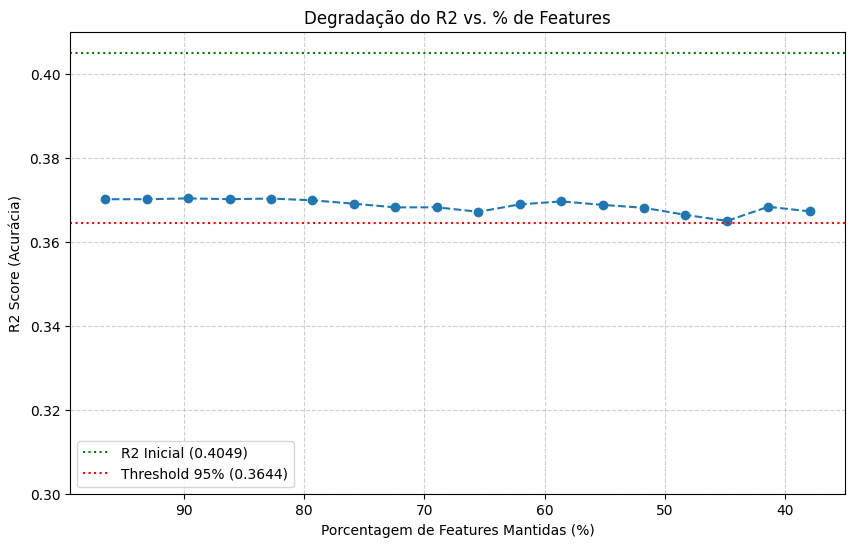

In [136]:
import matplotlib.pyplot as plt


df_log = pd.DataFrame(features_removed_log)

df_log['percent_features'] = df_log['features_remaining'].apply(lambda x: (x/len(feature_names))*100)

df_log = df_log.sort_values(by='percent_features')

plt.figure(figsize=(10, 6))
plt.plot(df_log['percent_features'], df_log['r2_score_after_removal'], marker='o', linestyle='--')
plt.axhline(y=r2_initial, color='green', linestyle=':', label=f'R2 Inicial ({r2_initial:.4f})')
plt.axhline(y=r2_threshold, color='red', linestyle=':', label=f'Threshold 95% ({r2_threshold:.4f})')
plt.xlabel("Porcentagem de Features Mantidas (%)")
plt.ylim(top=0.41, bottom=0.3)
plt.ylabel("R2 Score (Acurácia)")
plt.title("Degradação do R2 vs. % de Features")
plt.gca().invert_xaxis() # Inverte o eixo X (100% -> 0%)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Gerando Gráficos PCA/t-SNE...
Calculando PCA (Full)...
Calculando PCA (Reduced)...
Calculando t-SNE (Full)... 
Calculando t-SNE (Reduced)...


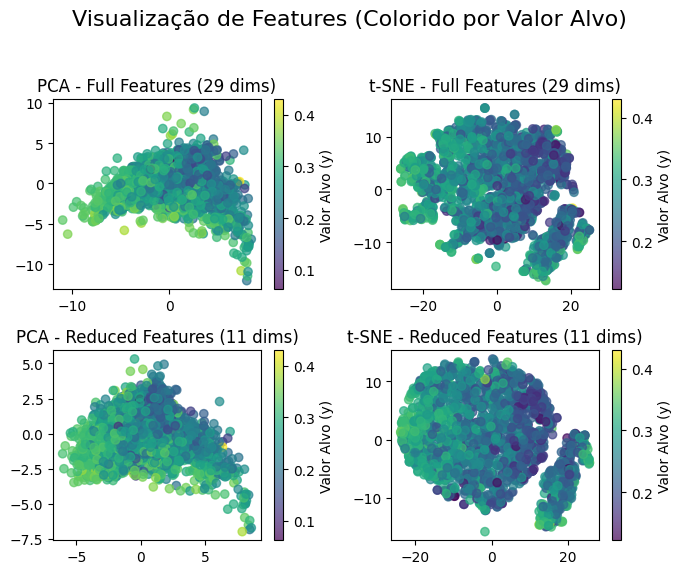

In [135]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Gerando Gráficos PCA/t-SNE...")

# Cenário 1: "Full Features" (Dados originais)
X_full = X_train


# Cenário 2: "Reduced Features" (Dados pós-RFE)
# Precisamos pegar os índices das features que sobraram
final_indices = [feature_names.index(name) for name in current_feature_names]
X_reduced = X_train[:, final_indices]

# Calcular componentes (limitamos o t-SNE a 500 amostras se for muito grande)
# Nota: t-SNE é lento. Para datasets grandes (ex: MBTR), use PCA ou fatie os dados.
n_samples_for_tsne = min(len(y_train), 2000)
sample_indices = np.random.permutation(len(y_train))[:n_samples_for_tsne]

print("Calculando PCA (Full)...")
pca_full = PCA(n_components=2).fit_transform(X_full)
print("Calculando PCA (Reduced)...")
pca_reduced = PCA(n_components=2).fit_transform(X_reduced)

print("Calculando t-SNE (Full)... ")
tsne_full = TSNE(n_components=2, perplexity=40, max_iter=400, random_state=42).fit_transform(X_full[sample_indices])
print("Calculando t-SNE (Reduced)...")
tsne_reduced = TSNE(n_components=2, perplexity=40, max_iter=400, random_state=42).fit_transform(X_reduced[sample_indices])

# Plotar os 4 gráficos
fig, ax = plt.subplots(2, 2, figsize=(7, 6))
fig.suptitle('Visualização de Features (Colorido por Valor Alvo)', fontsize=16)

# y_train para colorir
y_colors = y_train.values
y_colors_tsne = y_train.values[sample_indices]

# 1. PCA (Full)
cax1 = ax[0, 0].scatter(pca_full[:, 0], pca_full[:, 1], c=y_colors, cmap='viridis', alpha=0.7)
ax[0, 0].set_title(f'PCA - Full Features ({X_full.shape[1]} dims)')
fig.colorbar(cax1, ax=ax[0, 0], label='Valor Alvo (y)')

# 2. t-SNE (Full)
cax2 = ax[0, 1].scatter(tsne_full[:, 0], tsne_full[:, 1], c=y_colors_tsne, cmap='viridis', alpha=0.7)
ax[0, 1].set_title(f't-SNE - Full Features ({X_full.shape[1]} dims)')
fig.colorbar(cax2, ax=ax[0, 1], label='Valor Alvo (y)')

# 3. PCA (Reduced)
cax3 = ax[1, 0].scatter(pca_reduced[:, 0], pca_reduced[:, 1], c=y_colors, cmap='viridis', alpha=0.7)
ax[1, 0].set_title(f'PCA - Reduced Features ({X_reduced.shape[1]} dims)')
fig.colorbar(cax3, ax=ax[1, 0], label='Valor Alvo (y)')

# 4. t-SNE (Reduced)
cax4 = ax[1, 1].scatter(tsne_reduced[:, 0], tsne_reduced[:, 1], c=y_colors_tsne, cmap='viridis', alpha=0.7)
ax[1, 1].set_title(f't-SNE - Reduced Features ({X_reduced.shape[1]} dims)')
fig.colorbar(cax4, ax=ax[1, 1], label='Valor Alvo (y)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### IV. Analysis

Even though we have a small number of attributes (only 29), we still can take more than a half of its features maintaining 90% of its "accuracy" and at a very low computational cost.


Since it's a small feature elimination, the data distribution isn't so disparate from the original distribution.

### MBTR:

Some preprocessing methods such as dataset division and scaling are extremely important in this phase to ensure generalization.

In [95]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(mbtr_descriptors, df['gap'],
                                                    test_size=0.2, random_state=24)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We adjusted the alpha coeficient to ensure a better convergence of the model.

In [104]:
alpha = 1e-3
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)

Lasso(alpha=0.001)

In [105]:
y_train_pred = lasso.predict(X_train)

print(f"Train error: {mean_absolute_error(y_train.values, y_train_pred):.2f}")

y_test_pred = lasso.predict(X_test)
print(f"Test error: {mean_absolute_error(y_test.values,y_test_pred):.2f}")

Train error: 0.02
Test error: 0.02


We will use the $R^2$ score to determine how many features we can still use in the subset. While the $R^2$ score is still bigger than $95%$ of the initial $R^2$ score, we can keep selecting other subsets.

In [106]:
r2_initial = lasso.score(X_test, y_test)
print(r2_initial)

0.8193680215889932


In [107]:
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
current_X_train = X_train.copy()
current_X_test = X_test.copy()
current_feature_names = list(feature_names) # Cópia da lista de nomes

current_r2 = r2_initial
THRESHOLD = 0.95
r2_threshold = THRESHOLD*r2_initial

features_removed_log = []

In [108]:
print("Número de lambdas diferentes de 0:", len(lasso.coef_.nonzero()[0]))
print(f"Porcentagem do tamanho de features: {len(lasso.coef_.nonzero()[0])/len(feature_names)*100:.2f}%")

Número de lambdas diferentes de 0: 127
Porcentagem do tamanho de features: 2.67%


To fasten the convergence of our Feature Selection Algorithm, an heuristic will be used so that we can take bigger steps at the beginning of the iterations and closer steps at the end.

Observing the Lasso coeficients, we can evaluate that only 2% of the features have LASSO coeficients different than zero. This can show us that our minimum feature length to maintain 95% of accuracy will be far from beginning, so we can start taking large steps (100 features out per iteration) and when we achieve a feature size close to how many percentage of non-zeros features (here, we arbitrarily selected 30% of the total feature size), we start decaying this number of features.  

This allow us to a faster convergence while still cleverly using the LASSO regressor in our favor.

In [109]:
import time

start_time_mbtr = time.time()

n_features_to_remove = 100

while current_r2 >= r2_threshold and len(current_feature_names) > n_features_to_remove:

    model = Lasso(alpha=alpha)
    model.fit(current_X_train, y_train)

    importances = np.abs(model.coef_)

    # Get the indices of the features to remove (smallest importances)
    indices_to_remove = np.argsort(importances)[:n_features_to_remove]

    # Remove the features with the smallest importances
    removed_feature_names = [current_feature_names[i] for i in sorted(indices_to_remove, reverse=True)]
    current_feature_names = [current_feature_names[i] for i in range(len(current_feature_names)) if i not in indices_to_remove]

    current_X_train = np.delete(current_X_train, indices_to_remove, axis=1)
    current_X_test = np.delete(current_X_test, indices_to_remove, axis=1)

    eval_model = Lasso(alpha=alpha)
    eval_model.fit(current_X_train, y_train)

    current_r2 = eval_model.score(current_X_test, y_test)

    print(f"Removed: {removed_feature_names} | Features remaining: {len(current_feature_names):<3} | New R2: {current_r2:.5f}")

    log_entry = {
        'features_removed': removed_feature_names,
        'features_remaining': len(current_feature_names),
        'r2_score_after_removal': current_r2
    }
    features_removed_log.append(log_entry)

    # Using this heuristics to fasten the evaluation and allow a fine tuning of n° features to remove
    if len(current_feature_names)/len(feature_names) < 0.30:
        n_features_to_remove = int((n_features_to_remove)*0.9)
        if n_features_to_remove < 1:
            n_features_to_remove = 1

end_time_mbtr = time.time()
time_for_feat_selection_mbtr = end_time_mbtr - start_time_mbtr

print("\n--- Loop Interrupted ---")
if current_r2 < r2_threshold:
    print(f"Reason: R2 ({current_r2:.5f}) fell below the threshold ({r2_threshold:.5f})")


    last_removed = features_removed_log.pop()
    current_feature_names.extend(last_removed['features_removed'])
    print(f"Restoring the last removed features: {last_removed['features_removed']}")

else:
    print("Reason: Only 1 feature remaining.")

print("\n--- Final Result ---")
print(f"Final number of features: {len(current_feature_names)}")
print("Selected feature list:")
print(current_feature_names)

Removed: ['feature_3252', 'feature_3251', 'feature_3250', 'feature_3249', 'feature_3248', 'feature_3247', 'feature_3244', 'feature_3235', 'feature_3234', 'feature_3233', 'feature_3232', 'feature_3231', 'feature_3230', 'feature_3229', 'feature_3228', 'feature_3227', 'feature_3226', 'feature_3225', 'feature_3224', 'feature_3223', 'feature_3222', 'feature_3221', 'feature_3220', 'feature_3219', 'feature_3218', 'feature_3217', 'feature_3179', 'feature_3178', 'feature_3177', 'feature_3176', 'feature_3175', 'feature_3174', 'feature_3173', 'feature_3172', 'feature_3171', 'feature_3170', 'feature_3169', 'feature_3168', 'feature_3167', 'feature_3166', 'feature_3165', 'feature_3164', 'feature_3163', 'feature_3162', 'feature_3161', 'feature_3160', 'feature_3159', 'feature_3158', 'feature_3157', 'feature_3156', 'feature_3155', 'feature_3154', 'feature_3153', 'feature_3152', 'feature_3151', 'feature_3150', 'feature_3149', 'feature_3148', 'feature_3147', 'feature_3146', 'feature_3145', 'feature_3144'

In [110]:
print(f"Tempo de execução: {time_for_feat_selection_mbtr:.2f} segundos")

Tempo de execução: 191.84 segundos


In [111]:
final_feature_count = len(current_feature_names)
print(f"Número de features para 95% do R2: {final_feature_count}")

Número de features para 95% do R2: 22


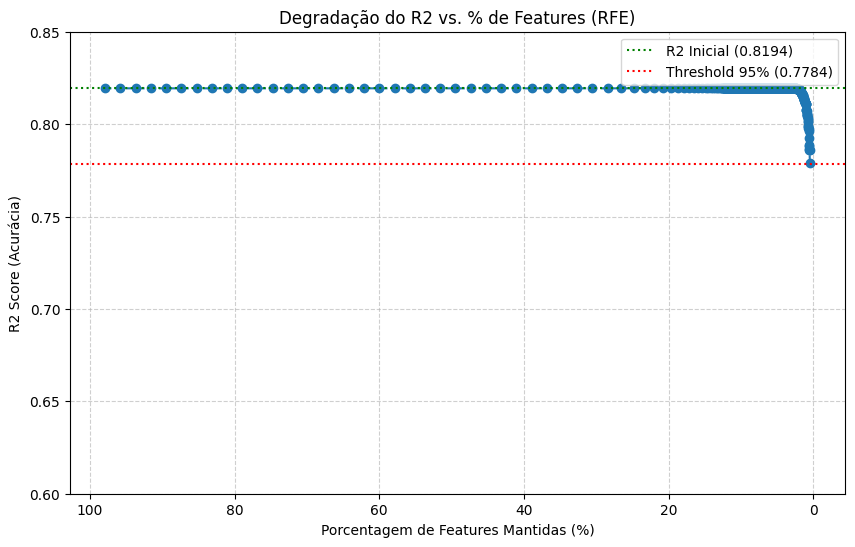

In [115]:
import matplotlib.pyplot as plt


df_log = pd.DataFrame(features_removed_log)

df_log['percent_features'] = df_log['features_remaining'].apply(lambda x: (x/len(feature_names))*100)

df_log = df_log.sort_values(by='percent_features')

plt.figure(figsize=(10, 6))
plt.plot(df_log['percent_features'], df_log['r2_score_after_removal'], marker='o', linestyle='--')
plt.axhline(y=r2_initial, color='green', linestyle=':', label=f'R2 Inicial ({r2_initial:.4f})')
plt.axhline(y=r2_threshold, color='red', linestyle=':', label=f'Threshold 95% ({r2_threshold:.4f})')
plt.xlabel("Porcentagem de Features Mantidas (%)")
plt.ylim(top=0.85, bottom=0.6)
plt.ylabel("R2 Score (Acurácia)")
plt.title("Degradação do R2 vs. % de Features")
plt.gca().invert_xaxis() # Inverte o eixo X (100% -> 0%)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Gerando Gráficos PCA/t-SNE (Tarefa IV)...
Calculando PCA (Full)...
Calculando PCA (Reduced)...
Calculando t-SNE (Full)... 
Calculando t-SNE (Reduced)...


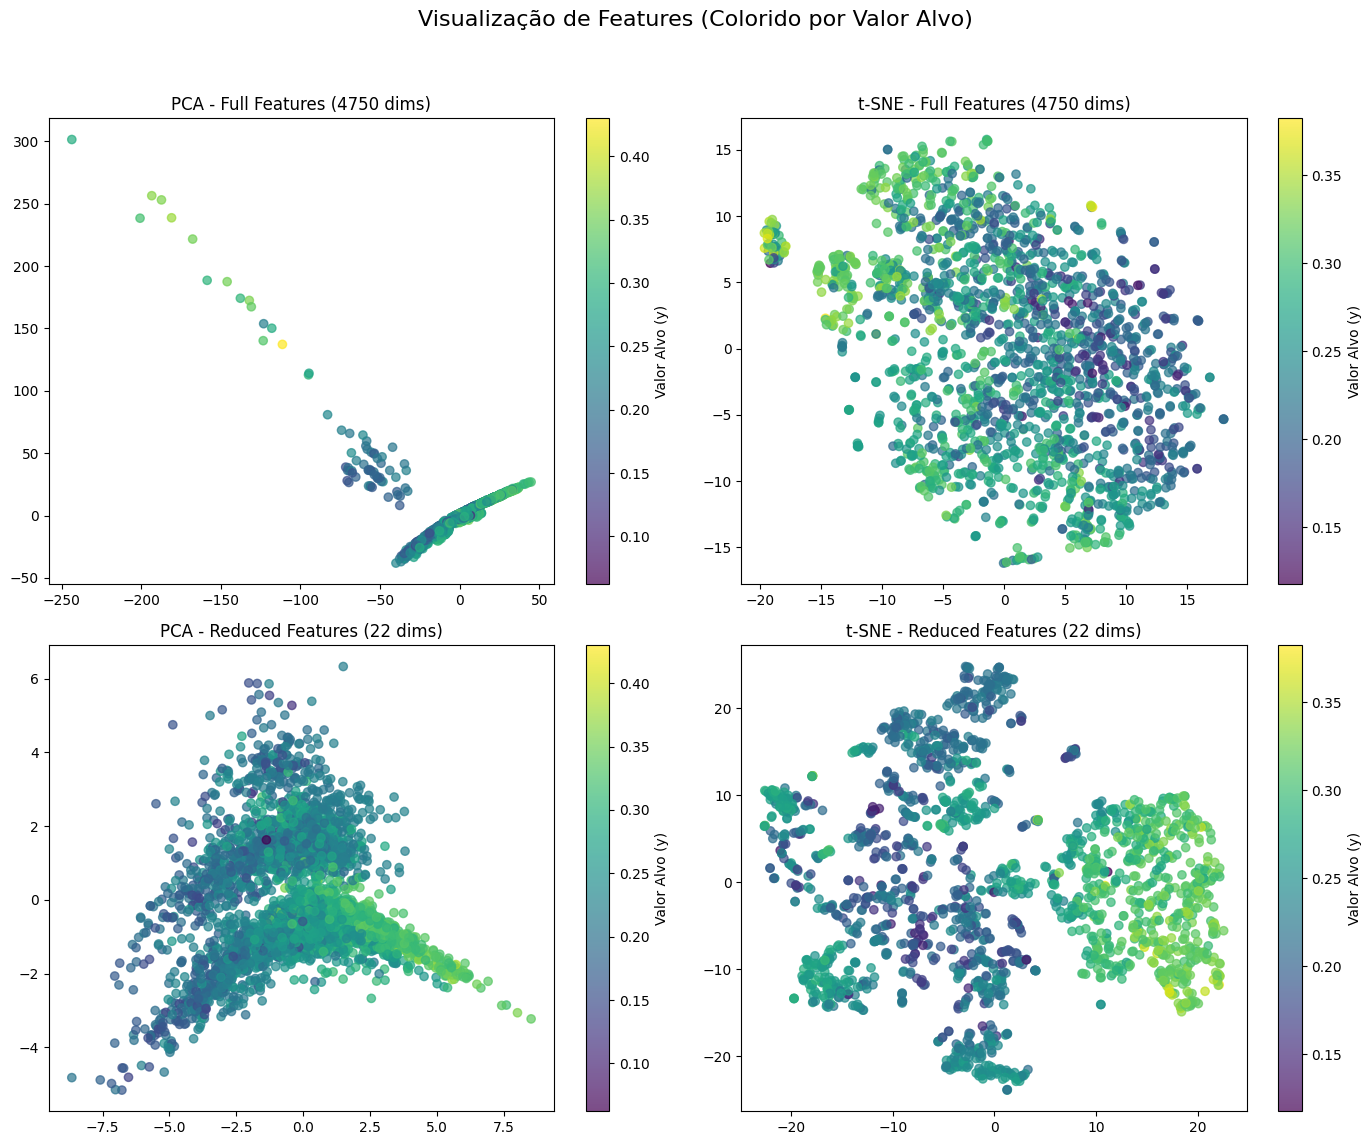

In [117]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Gerando Gráficos PCA/t-SNE...")

# Cenário 1: "Full Features" (Dados originais)
X_full = X_train


# Cenário 2: "Reduced Features" (Dados pós-RFE)
# Precisamos pegar os índices das features que sobraram
final_indices = [feature_names.index(name) for name in current_feature_names]
X_reduced = X_train[:, final_indices]

# Calcular componentes (limitamos o t-SNE a 500 amostras se for muito grande)
# Nota: t-SNE é lento. Para datasets grandes (ex: MBTR), use PCA ou fatie os dados.
n_samples_for_tsne = min(len(y_train), 2000)
sample_indices = np.random.permutation(len(y_train))[:n_samples_for_tsne]

print("Calculando PCA (Full)...")
pca_full = PCA(n_components=2).fit_transform(X_full)
print("Calculando PCA (Reduced)...")
pca_reduced = PCA(n_components=2).fit_transform(X_reduced)

print("Calculando t-SNE (Full)... ")
tsne_full = TSNE(n_components=2, perplexity=40, max_iter=400, random_state=42).fit_transform(X_full[sample_indices])
print("Calculando t-SNE (Reduced)...")
tsne_reduced = TSNE(n_components=2, perplexity=40, max_iter=400, random_state=42).fit_transform(X_reduced[sample_indices])

# Plotar os 4 gráficos
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Visualização de Features (Colorido por Valor Alvo)', fontsize=16)

# y_train para colorir
y_colors = y_train.values
y_colors_tsne = y_train.values[sample_indices]

# 1. PCA (Full)
cax1 = ax[0, 0].scatter(pca_full[:, 0], pca_full[:, 1], c=y_colors, cmap='viridis', alpha=0.7)
ax[0, 0].set_title(f'PCA - Full Features ({X_full.shape[1]} dims)')
fig.colorbar(cax1, ax=ax[0, 0], label='Valor Alvo (y)')

# 2. t-SNE (Full)
cax2 = ax[0, 1].scatter(tsne_full[:, 0], tsne_full[:, 1], c=y_colors_tsne, cmap='viridis', alpha=0.7)
ax[0, 1].set_title(f't-SNE - Full Features ({X_full.shape[1]} dims)')
fig.colorbar(cax2, ax=ax[0, 1], label='Valor Alvo (y)')

# 3. PCA (Reduced)
cax3 = ax[1, 0].scatter(pca_reduced[:, 0], pca_reduced[:, 1], c=y_colors, cmap='viridis', alpha=0.7)
ax[1, 0].set_title(f'PCA - Reduced Features ({X_reduced.shape[1]} dims)')
fig.colorbar(cax3, ax=ax[1, 0], label='Valor Alvo (y)')

# 4. t-SNE (Reduced)
cax4 = ax[1, 1].scatter(tsne_reduced[:, 0], tsne_reduced[:, 1], c=y_colors_tsne, cmap='viridis', alpha=0.7)
ax[1, 1].set_title(f't-SNE - Reduced Features ({X_reduced.shape[1]} dims)')
fig.colorbar(cax4, ax=ax[1, 1], label='Valor Alvo (y)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

###


#### IV. Analysis

With MBTR we can see that the Feature Selection was really effective. Reducing the feature vector from 4750 dimensions into 22 dimensions without any transformation in the data in around 3 minutes was possible thanks to the heuristics in the number of deleted features per step.

Also, the more compact nature of the PCA plot with reduced features, and the continued clarity of clusters in the t-SNE plot, suggest that many of the original 4750 features were likely redundant or noisy. By removing them, we obtain a cleaner representation.

